<a href="https://colab.research.google.com/github/DerManjuel/MDL/blob/main/MDL_Exercise4_Explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Deep Learning
## Exercise 4: Weakly-Supervised Visualization

The goal of this exercise is to implement methods that allow to gain insights which parts of an input image to a Deep Neural Network are pivotal for its classification decision. Because of their conception as black-box-system, especially in Medical Imaging this is important for user acceptance.

![explainability](https://drive.google.com/uc?export=view&id=1oDUfMmOpopV8Dnv4rvHmqmxMcIK8JLYI)

In [ ]:
################################################################
## TRAIN_IMGS.PTH IN DEN ORDNER EINFÜGEN - ZU GROß FÜR GitHub ##
################################################################

In [1]:
import torch
import torchvision
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from collections import OrderedDict
import matplotlib.cm as mpl_color_map
import os
#import wget
import zipfile
from tqdm.notebook import trange, tqdm

%matplotlib inline
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
'''dataset_url = 'https://cloud.imi.uni-luebeck.de/s/KwD3fs4q6ctqmA8/download'

def get_data(data_url):
    filename = 'MDL3_data.zip'
    if not os.path.exists(filename):
        !wget -O '/Data/MDL3_data.zip' 'https://cloud.imi.uni-luebeck.de/s/KwD3fs4q6ctqmA8/download'
        #filename = wget.download(data_url)
    zipfile.ZipFile(filename,'r').extractall()
    
get_data(dataset_url)'''

"dataset_url = 'https://cloud.imi.uni-luebeck.de/s/KwD3fs4q6ctqmA8/download'\n\ndef get_data(data_url):\n    filename = 'MDL3_data.zip'\n    if not os.path.exists(filename):\n        !wget -O '/Data/MDL3_data.zip' 'https://cloud.imi.uni-luebeck.de/s/KwD3fs4q6ctqmA8/download'\n        #filename = wget.download(data_url)\n    zipfile.ZipFile(filename,'r').extractall()\n    \nget_data(dataset_url)"

In [3]:
# Function for Heatmap Overlays (expects gray-scale image as numpy and heatmap as torch array)
def overlayParula(grayim_numpy: np.ndarray, heatmap_torch: torch.Tensor, smooth : bool=False):
    
    heat_max = torch.kthvalue(heatmap_torch.view(-1), int(.95*heatmap_torch.numel()))[0]
    heat_min = torch.min(heatmap_torch)
    heatmap_torch = torch.clamp((heatmap_torch-heat_min)/(heat_max-heat_min),0,1)
    if(smooth==True):
        heatmap_torch = F.avg_pool2d(F.avg_pool2d(F.max_pool2d(heatmap_torch.unsqueeze(0).unsqueeze(0),3,stride=1,padding=1),3,stride=1,padding=1),3,stride=1,padding=1).squeeze()


    x = np.linspace(0.0, 1.0, 256)
    rgb_jet = plt.colormaps.get_cmap(plt.colormaps['jet'])(x)[:,:3]  #plt.get_cmap('jet')
    rgb_gray = plt.colormaps.get_cmap(plt.get_cmap('gray'))(x)[:,:3] #mpl_color_map.get_cmap(plt.get_cmap('gray'))(x)[:,:3]
    #rgb_viridis
    rgb_heat = rgb_jet[(heatmap_torch*255).numpy().astype('uint8'),:]
    rgb_base = rgb_gray[(grayim_numpy*255).astype('uint8'),:]

    rgb0 = (rgb_heat*127.5+rgb_base*127.5).astype('uint8')
    weight = torch.tanh((heatmap_torch-0.5)*3)*0.5+0.5
    alpha = torch.clamp(1.0 - 0.5*weight,0,1.0)
    overlay = rgb_base*alpha.unsqueeze(2).numpy() + rgb_heat*(1.0-alpha).unsqueeze(2).numpy()
        
    return overlay

# Function to compute the number of trainable parameters in a given model
def countParameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

# Function to compute the Dice value given the ground truth segmentation of a slice
# and the guided_backpropagation_map or the CAM map as <pred>
def oracle_dice(pred,gt_th):
    val,idx = torch.sort(pred.data.flatten(),descending=True)
    gt_sort = gt_th.flatten()[idx]
    intersect = torch.cumsum(gt_sort,0).float()
    cardinal = (gt_th.flatten()>0.5).float().sum()+torch.arange(pred.numel(), device=gt_th.device).float()
    all_dices = 2*intersect/torch.clamp(cardinal,min=.001)
    return all_dices.max(),val[all_dices.argmax()]

## Task 0 (15 points): Implement dataset and visualize the given pancreas train & test data
We start with implementing the `PancreasDataSet`, which loads the training and test data respectively to its `mode` (`train` or `test`). For training data only the labels are given, for the test datasets also segmentation masks are provided. Because our pretrained CNN on ImageNet expects an RGB-image, we stack three neighboring slices of the CT as feature channels.
The training data are given as a list of tensors with shape $[64\times3\times224\times224]$ for the image and $[64]$ for the labels.
+ load the data and its labels accordingly to the dataset's mode and concatenate each list to one tensor in dimension $N$ using `torch.cat`
+ divide the images with 255 to map them to $[0, 1]$
+ if `mode=='test'` load the segmentation masks and concatenate them like above
+ z-standardize the images to match the ImageNet value distribution with the provided statistic
+ complete the `__len__` and `__getitem__` functions
    + **NOTE** the number of returned data differs between the `mode`s. Please use following order for the return statements: images, labels, (segmentations)


In [4]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class PancreasDataSet(Dataset):
    def __init__(self, mode: str, normalize: bool=True):
        """
        constructor
        :param mode: decides whether the training or test split should be loaded
        :param normalize: normalize the images with the given statistics
        """
        assert mode in ['train', 'test']
        self.mode = mode
        super(PancreasDataSet, self).__init__()
        
        # load data
        # todo
        self.imgs = torch.load('MDL3_data/train_imgs.pth') if self.mode == 'train' else torch.load('MDL3_data/test_imgs.pth')
        #print(type(self.imgs[0])) # -> here it is of type list, with index 0 its tensor
        self.imgs = torch.cat(self.imgs, dim=0)
        self.imgs = self.imgs/255

        # load lables
        # todo
        self.labels = torch.load('MDL3_data/train_labels.pth') if self.mode == 'train' else torch.load('MDL3_data/test_labels.pth')
        self.labels = torch.cat(self.labels, dim=0) # -> same issue as imgs, we need indexing to get the tensor
        #print(self.imgs.shape, self.labels.shape)

        if mode == 'test':
            # load segmentations
            # todo
            self.segmentations = torch.load('MDL3_data/test_segmentations.pth')
            self.segmentations = torch.cat(self.segmentations, dim=0)
            #print(len(self.imgs), len(self.labels), len(self.segmentations))
            assert len(self.imgs) == len(self.labels) == len(self.segmentations)
        assert len(self.imgs) == len(self.labels)
        
        # normalize data
        if normalize:
            # Below we provide the mean and std values from the ImageNet data
            means = torch.Tensor([0.485, 0.456, 0.406])
            stds = torch.Tensor([0.229, 0.224, 0.225])
            # normalisation
            print(self.imgs.shape)
            self.imgs[:,0,:,:] = (self.imgs[:,0,:,:] - means[0]) / stds[0]
            self.imgs[:,1,:,:] = (self.imgs[:,1,:,:] - means[1]) / stds[1]
            self.imgs[:,2,:,:] = (self.imgs[:,2,:,:] - means[2]) / stds[2]
            
    def __getitem__(self, index):
        if self.mode == 'train':
            # todo
            assert index <= self.__len__(), "Oh no! Index is too big!"
            return self.imgs[index], self.labels[index]
        else:
            # todo
            assert index <= self.__len__(), "Oh no! Index is too big!"
            return self.imgs[index], self.labels[index], self.segmentations[index]
    
    def __len__(self):
        # todo
        return len(self.imgs)

In [5]:
ds = PancreasDataSet(mode='test')
image, label, segs = ds.__getitem__(15)
#print(image.shape, label)

torch.Size([320, 3, 224, 224])


### Visualize some random input training & test slices
ds = PancreasDataSet()

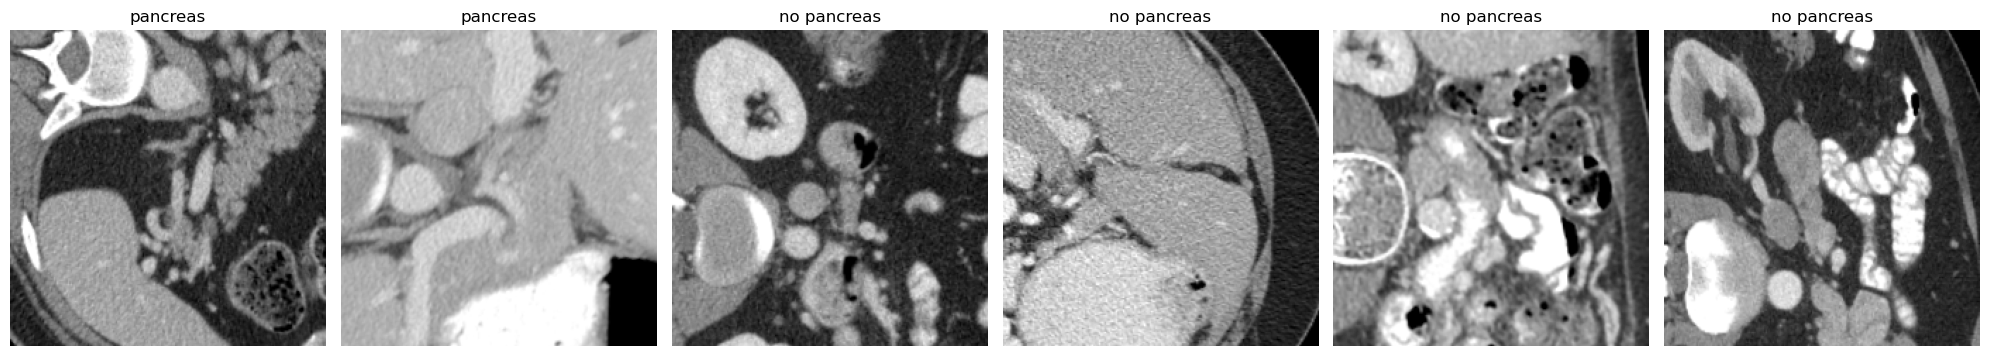

In [6]:
ds = PancreasDataSet('test', normalize=False)
label = ['no pancreas', 'pancreas']
n_plots = 6
rnd_idx = torch.randperm(len(ds))[:n_plots]

fig, axs = plt.subplots(1, n_plots, figsize=(20, 5))
for i, idx in enumerate(rnd_idx):
    img, lbl, _ = ds[idx]
    axs[i].imshow(img[1], cmap='gray')
    axs[i].set_title(label[lbl.item()])
    axs[i].set_axis_off()
fig.tight_layout()

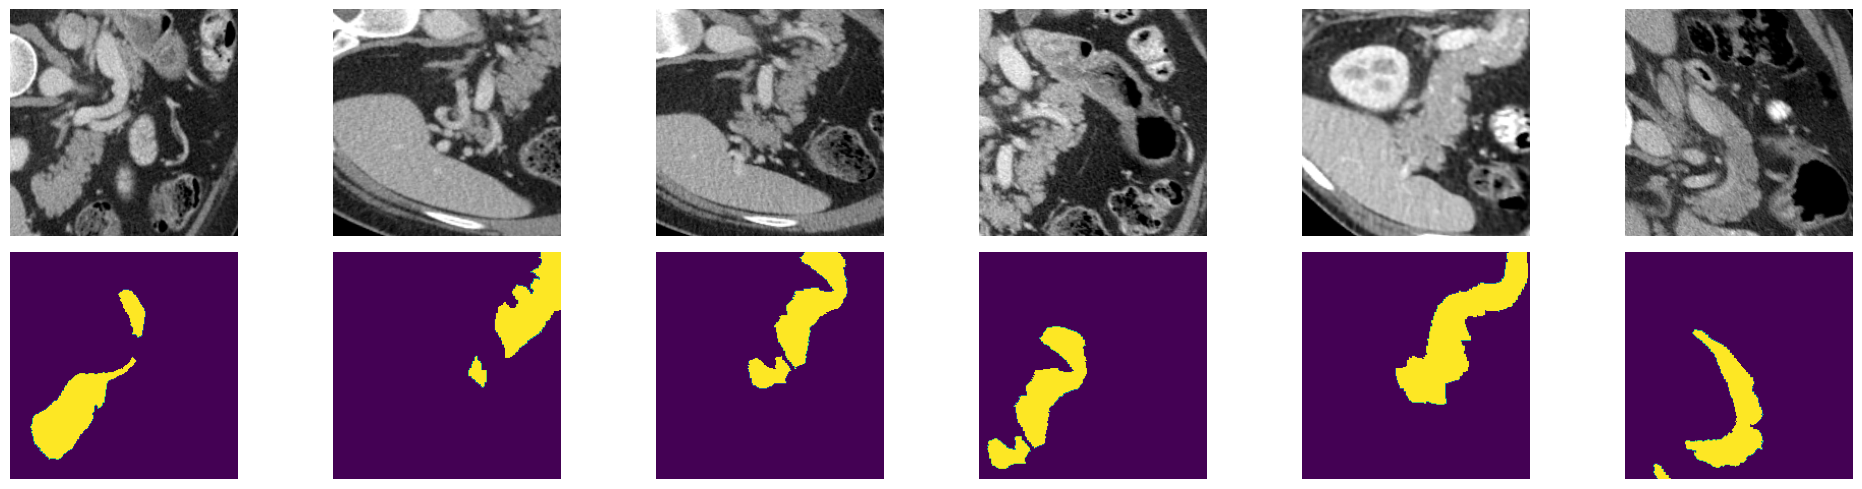

In [7]:
rnd_idx = torch.arange(len(ds))[ds.labels == 1]
rnd_idx = rnd_idx[torch.randperm(len(rnd_idx))[:n_plots]]

fig, axs = plt.subplots(2, n_plots, figsize=(20, 5))
for i, idx in enumerate(rnd_idx):
    axs[0, i].imshow(ds.imgs[idx, 1], cmap='gray')
    axs[0, i].set_axis_off()
    
    axs[1, i].imshow(ds.segmentations[idx])
    axs[1, i].set_axis_off()
fig.tight_layout()

## Task 1 (25 points): Finetune a pretrained ResNet on the given data
Before we can fine tune the pretrained CNN on our data, we have to modify its architecture to our needs.
+ load the **pretrained** ResNet18 from the torchvision model zoo
+ get familiar with the architecture's structure
    + print its layers with their settings using the `print` function
    + check the corresponding output shapes with `torchinfo.summary`

In [8]:
from torchinfo import summary
# load model
# todo
model = models.resnet18(progress=True)

# inspect architecture
# todo
print(model)
summary(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

With foresight to the gradCAM method, we need the last feature layer to have a sufficiently large spatial dimensions therefore we need to replace the ResNet.Layer4 Sequential block with an identity operation (`nn.Identity`). Since in addition to a larger spatial output of the last feature layer, we also want a more lightweight model, we modify the building blocks of Layer3:

1. Replace `conv1` in `layer3[0]` with a Conv2D: (in=128,out=256,k_sz=3, stride=1, pad=1, bias=False)
2. Replace `conv2` in `layer3[0]` with a Conv2D: (in=256,out=256,k_sz=3, stride=1, dil=2, pad=2, bias=False)
3. Replace `downsample[0]` in `layer3[0]` with a Conv2D: (in=128,out=256,k_sz=1, stride=1, pad=0, bias=False)
4. Replace `conv1` in `layer3[1]` with a Conv2D: (in=256,out=256,k_sz=3, stride=1, dil=2, pad=2, bias=False)
5. Replace `conv2` in `layer3[1]` with a Conv2D: (in=256,out=256,k_sz=3, stride=1, dil=2, pad=2, bias=False)

Finally: replace the fully connected layer: Inspect the number of input & output channels for the ImageNet classification task and modify this layer accordingly to our "(presence/absence) of the pancreas" classification problem.

Now, we have a ResNet14. Check its architecture using `summary`. You should obtain a total count of $2.783.298$ parameters.

In [9]:
# TODO replace the 4th layer with an identity mapping
# todo
model.layer4 = nn.Identity()

# TODO: replace the modules according to the description given above
model.layer3[0].conv1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False)
model.layer3[0].conv2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, dilation=2, padding=2, bias=False)
model.layer3[0].downsample[0] = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=1, padding=0, bias=False)
model.layer3[1].conv1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, dilation=2, padding=2, bias=False)
model.layer3[1].conv2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, dilation=2, padding=2, bias=False)

# TODO: replace the fully connected layer
# todo 2 or 1 in out_features???
model.fc = nn.Linear(in_features=256, out_features=2, bias=True)

# TODO: print the summary
# todo
print(model)
summary(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

Now let's finetune the ResNet14 to our training data:
+ create two dataloader (hint: set `pin_memory=True` for speed up during CPU→GPU transfer)
    + choose a batch size of 32 for training and shuffle the dataset after every epoch
    + you can double the batch size for testing 
- use Adam in combination with an exponential learning rate scheduler ($\gamma=0.95$) and cross entropy
- you should easily achieve accuracy scores on the training data of > 0.98 after 3 epochs
- your validation accuracy should be ~80% after 10 epochs

In [10]:
# Set the device
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda"
print(device)

mps


In [11]:
dl_train = DataLoader(PancreasDataSet('train', normalize=True), batch_size=32, shuffle=True, pin_memory=True) # todo
dl_test = DataLoader(PancreasDataSet('test', normalize=True), batch_size=64, shuffle=True, pin_memory=True) # todo


torch.Size([2560, 3, 224, 224])
torch.Size([320, 3, 224, 224])


In [12]:
model.to(device)

num_epochs = 10

# optimizer
optimizer = torch.optim.Adam(model.parameters())

# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# criterion
criterion = torch.nn.CrossEntropyLoss()

# for reproducibility (do not change)
torch.manual_seed(0)

# statistics
train_loss = torch.zeros(num_epochs, device=device)
train_acc = torch.zeros_like(train_loss)

test_loss = torch.zeros_like(train_loss)
test_acc = torch.zeros_like(train_loss)

# for num_epochs
for epoch in trange(num_epochs, unit='epoch'):

    # train mode
    model.train()

    # for each mini-batch
    for input, target in dl_train:
        input = input.to(device)
        target = target.to(device)

        # zero the parameter gradients
        # todo
        optimizer.zero_grad()

        # forward + backward + optimize
        # todo
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # statistics
        train_loss[epoch] += loss.detach()
        train_acc[epoch] += torch.mean((torch.argmax(output, dim=-1) == target).float())

    # update learning rate
    # todo
    lr_scheduler.step()

    train_loss[epoch] /= len(dl_train)
    train_acc[epoch] /= len(dl_train)

    # output
    tqdm.write('Epoch {} (train) -- loss: {:.4f} accuracy: {:.4f}'.format(epoch, train_loss[epoch].item(), train_acc[epoch].item()))

    # validate
    with torch.no_grad():

        # eval mode
        model.eval()

        # for each mini-batch
        for input, target, _ in dl_test:
            input = input.to(device)
            target = target.to(device)

            # forward
            # todo
            output = model(input)
            loss = criterion(output, target)

            # statistics
            test_loss[epoch] += loss.detach()
            test_acc[epoch] += torch.mean((torch.argmax(output, dim=-1) == target).float())

        test_loss[epoch] /= len(dl_test)
        test_acc[epoch] /= len(dl_test)

        # output
        tqdm.write('Epoch {} (valid) -- loss: {:.4f} accuracy: {:.4f}'.format(epoch, test_loss[epoch].item(), test_acc[epoch].item()))
        
torch.save(model, 'pancreas_model.pt')

  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0 (train) -- loss: 0.4327 accuracy: 0.8066
Epoch 0 (valid) -- loss: 1.2651 accuracy: 0.5375
Epoch 1 (train) -- loss: 0.2093 accuracy: 0.9219
Epoch 1 (valid) -- loss: 1.0252 accuracy: 0.6500
Epoch 2 (train) -- loss: 0.1756 accuracy: 0.9305
Epoch 2 (valid) -- loss: 1.0781 accuracy: 0.7094
Epoch 3 (train) -- loss: 0.1217 accuracy: 0.9527
Epoch 3 (valid) -- loss: 0.9717 accuracy: 0.6656
Epoch 4 (train) -- loss: 0.1078 accuracy: 0.9617
Epoch 4 (valid) -- loss: 1.6232 accuracy: 0.6344
Epoch 5 (train) -- loss: 0.0768 accuracy: 0.9723
Epoch 5 (valid) -- loss: 0.6505 accuracy: 0.7656
Epoch 6 (train) -- loss: 0.0436 accuracy: 0.9855
Epoch 6 (valid) -- loss: 1.6723 accuracy: 0.6375
Epoch 7 (train) -- loss: 0.0440 accuracy: 0.9832
Epoch 7 (valid) -- loss: 1.0628 accuracy: 0.7281
Epoch 8 (train) -- loss: 0.0483 accuracy: 0.9852
Epoch 8 (valid) -- loss: 1.1997 accuracy: 0.7531
Epoch 9 (train) -- loss: 0.0672 accuracy: 0.9758
Epoch 9 (valid) -- loss: 1.9258 accuracy: 0.6562


![cam](https://drive.google.com/uc?export=view&id=1CBjTBKCdTHFi6MDoz0hJ1y-Faat56Krz)
## Task 2 (30 points): implement the CAM method
Now that we have our trained ResNet14 at hand, we want to visualize the class activation map (CAM).
Therefore, we need to implement the following steps:

+ Beforehand, the fully connected layer operated on 256-channel images without spatial dimensions only due to the `nn.AdaptivePooling` layer. Now, we want to weight each of the $28\times28$ spatial features with their 256-channels using the trained weights from the fully connected layer. In order to do so, extract the weights for the class activation map from the fully connected layer's weight (remember that we are only interested in the weights for the 'pancreas presence' class).
+ Since we are interested in the last convolutional feature layer output, we want to omit the avg_pool & fc layer. (Hint: use `torch.nn.Sequential(*list(model.children())[:-k])`)

In [39]:
# load the net
model = torch.load('pancreas_model.pt')
# extract weights for cam
cam_weight = model.fc.weight[1].to('cpu')
print(cam_weight.shape)
# remove the avg and fc layer
truncated_model = torch.nn.Sequential(*list(model.children())[:-2])
summary(truncated_model)

torch.Size([256])


Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

In [33]:
# provided function for plotting the activation heatmaps and comparing them to the ground truth
def plot_activations(img: torch.Tensor, activation_heatmap: torch.Tensor, segmentation: torch.Tensor):
    
    img = img[:,1].squeeze().cpu().numpy()
    # img = img[1].squeeze().cpu().numpy() # -> geht nicht, da dim0 nur ein Element hat, daher umschreiben wie oben
    # print(img.shape) # -> 224,224 <-
    
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(overlayParula(img, activation_heatmap.cpu().squeeze(), smooth=True))
    axs[0].set_axis_off()
    axs[0].set_title('prediction')
    
    axs[1].imshow(overlayParula(img, segmentation.cpu(), smooth=False))
    axs[1].set_axis_off()
    axs[1].set_title('ground truth')

Next, we want to generate our segmentation from the latent space. Therefore
+ feed the normalized image through our modified model
+ generate the CAM, therefore
    + multiply each feature map with its corresponding weight of the fully connected classifier
    + sum over all feature maps to create a CAM
    + upsample the CAM to the spatial dimension of the input image
+ visualize and compare the CAM with the given ground truth using the provided `plot_activations` function.
+ Finally, use the `oracle_dice` function to compute the DICE score (~0.6mean) between the ground truth and the CAM-based segmentation - remember: using only weak labels during the training stage!

/var/folders/g6/x4tl74v50ws8d3m02r0_9d6m0000gn/T/ipykernel_10218/28827466.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cam = torch.mul(feature_map.to('cpu'), torch.tensor(cam_weight.view(1,-1,1,1)))


mean dice: 0.22168301045894623


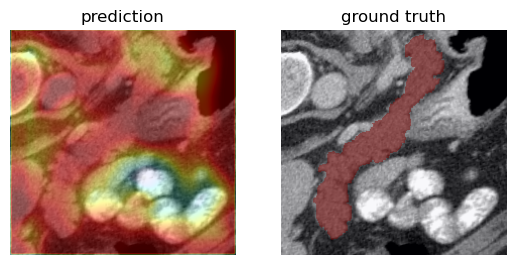

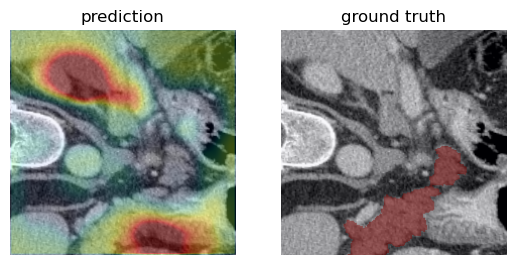

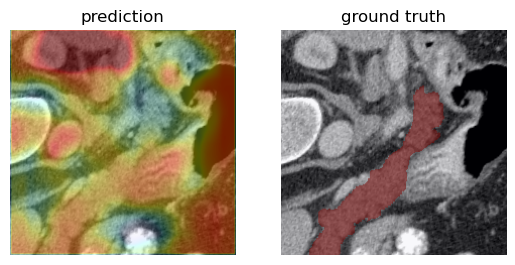

In [49]:
from torchmetrics import Dice
dice_all = []
for test_idx in range(256,262,2):
    # skip img without pancreas
    if(ds.labels[test_idx]==0):
        continue
    
    img_normalized = dl_test.dataset.imgs[test_idx].unsqueeze(0).to(device)
    img = ds.imgs[test_idx].to(device)
    seg = ds.segmentations[test_idx].to(device)
    
    with torch.no_grad():
        # feed the test image through the modified net
        feature_map = truncated_model(img_normalized)
        # generate cam
        # print(feature_map.shape, cam_weight.view(1,-1,1,1).shape)
        cam = torch.mul(feature_map.to('cpu'), torch.tensor(cam_weight.view(1,-1,1,1)))
        cam = torch.sum(cam, dim=1, keepdim=True)
        # print('after calculations', cam.shape)
        # upsample the activation map -> use scale_factor, because size=224 does not work
        upsample = nn.Upsample(scale_factor=8, mode='bilinear')
        # print(cam.unsqueeze(0).shape) -> upsample erwartet 4D Tensor -> N,C,H_in,W_in
        # so kommen wir von 1,28,28 auf 1,1,28,28 und upsample skaliert die letzen beiden Dimensionen
        cam = upsample(cam)
        # print('upsampled:', cam.shape) # -> 1,1,224,224
    
    # visualize the overlay  
    # print(img_normalized.shape) # -> 1,3,224,224 but we need 224,224 to display. rewrite following function
    # print(img.shape, cam.shape, seg.shape)
    plot_activations(img=img.unsqueeze(0), activation_heatmap=cam, segmentation=seg)

    # compute the dice score & append it to dice_all
    # todo -> was kommt hier ein? segmentierung ist ja ground truth,
    #dice = Dice()
    #print(img_normalized[:,1].squeeze().shape, cam.shape)
    x, y = oracle_dice(cam.to('cpu'), seg.int().to('cpu'))
    dice_all.append(x)

    
print('mean dice:', torch.stack(dice_all).mean().item())

## Task 3 (30 points): implement the guided backpropagation
(see also: http://blog.qure.ai/notes/deep-learning-visualization-gradient-based-methods)

The idea of GuidedBackprop is to supress gradient flow at positions where either of input or incoming gradients were negative.
Luckily, implementing this idea in PyTorch is quite comfortable, since it allows to write own layers - and especially also to define the backpropagation step on the Python-level, i.e. without having to code in CUDA explicitly, when ultimate performance is not necessary.

1. In order to use our pretrained ResNet14, we need to replace the ReLU functions by customized ReLUs that suppress the negative gradient flows according to the above stated cases.

2. Afterward, we need to implement to guided backpropagation steps.

### Implementing the custom ReLU-Layer
(See https://pytorch.org/docs/stable/notes/extending.html for further examples on how to implement custom functions & layers and http://cs231n.github.io/optimization-2/#backprop to refresh your knowledge on local backpropagation using the chain rule if needed.)

The cell below contains a simple example of a modified square function. Instead of computing the derivative of $x^2$ as $\frac{\partial}{\partial x}(x^2) = 2x$, our the customized square function sets this to $4x$ during the backward step. 

In [31]:
#example for a custom function and its nn-module
class SquareFunction(torch.autograd.Function):
    # Note that both forward and backward are @staticmethods
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        output = input**2
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        input = ctx.saved_tensors
        grad_input = grad_output*4.0*input[0].float()
        return grad_input
    
    
class SquareLayer(torch.nn.Module):
    def __init__(self):
        super(SquareLayer, self).__init__()
   
    def forward(self, x):
        SqFct = SquareFunction.apply
        x = SqFct(x)
        return x
    
    
test = torch.arange(4).view(2,2).float()
test.requires_grad = True

mySQLayer = SquareLayer()
out = mySQLayer(test)
print('input:', test)
print('output:', out)
back = torch.ones(2,2)
out.backward(back)
print('gradient:', test.grad)

input: tensor([[0., 1.],
        [2., 3.]], requires_grad=True)
output: tensor([[0., 1.],
        [4., 9.]], grad_fn=<SquareFunctionBackward>)
gradient: tensor([[ 0.,  4.],
        [ 8., 12.]])


![guided backpropagation](https://drive.google.com/uc?export=view&id=1kC5h6E9j2lXVLZw0cvkow4N_IcDi1deY)

Based on the customized square function as an example, you now have to implement a custom `GradReluLayer`, that cancels out gradient flow where either the input values or the gradient values at the layers output are negative (see guided backpropagation in figure above).
To verify your implementation, also write your own sanity check.

In [35]:
#define custom relu function and its nn-module
class GradReluFunction(torch.autograd.Function):
    # Note that both forward and backward are @staticmethods
    @staticmethod
    def forward(ctx, input):
        # todo
        ctx.save_for_backward(input)
        output = torch.relu(input)
        #output[output < 0] = 0
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        # todo
        eingabe = ctx.saved_tensors
        grad_output[grad_output < 0] = 0
        grad_output[eingabe[0]<0] = 0
        grad_input = grad_output

        return grad_input
    
    
class GradReluLayer(torch.nn.Module):
    def __init__(self):
        super(GradReluLayer, self).__init__()
   
    def forward(self, x):
        # todo
        customReLu = GradReluFunction.apply
        x = customReLu(x)
        return x

In [36]:
# WARUM IST DAS SO KOMISCH??????
GReLU = GradReluLayer()

t_in1 = torch.Tensor([[-2,-1],[2,2]])
t_in1.requires_grad = True
t_out1 = GReLU(t_in1)
grads = torch.Tensor([[-1,1],[1,-1]])
t_out1.backward(grads)

print('input: \n', t_in1)
print('output: \n', t_out1)
print('gradient: \n', t_in1.grad)
#should zero all negative gradients


# write your own sanity check!

input: 
 tensor([[-2., -1.],
        [ 2.,  2.]], requires_grad=True)
output: 
 tensor([[0., 0.],
        [2., 2.]], grad_fn=<GradReluFunctionBackward>)
gradient: 
 tensor([[0., 0.],
        [1., 0.]])


In [37]:
#GIVEN FUNCTION to replace all default ReLUs
def replaceFunc(model):
    if(isinstance(model,nn.Sequential)):
        if(len(model)>1):
            for i in range(len(model)):
                replaceFunc(model[i])
    for i,j in model._modules.items():
        if(isinstance(j,nn.ReLU)):
            model._modules[i] = GradReluLayer()
            
        if(isinstance(j,nn.Sequential)):
            model._modules[i] = replaceFunc(model._modules[i])
    return model

Having the customized ReLU-layer at hands, we are now able to implement the guided backward propagation scheme.
1. Define a function `guided_backprop` that expects
    + a test_image of size [1, 3, 224, 224]
    + the pretrained ResNet with customized ReLUs
    + a target_class
    + the output will be the guided gradient image
2. as a first step when calling the function, make sure that gradients will be computed for the input image
3. forward propagate the image through the pretrained model (in evaluation mode!)
4. having constructed the autograd graph, we set the gradients of the model to zero
5. next, we backpropagate a one-hot-tensor (for the correct class) through this graph towards the input. Therefore, we set our one-hot-tensor as `gradient` in the `backward` call.
6. finally, return the summed along the channels (absolute values) gradient image as output

In [38]:
def guided_backprop(input_img, pretrained_model, target_class):
    #APPLY GUIDED BACKPROP!
    print(input_img.shape)
    # ensure gradient flow up until input
    # todo
    input_img.requires_grad = True
    
    #important: set model in evaluation mode!
    # todo
    pretrained_model.eval()
    
    # forward pass
    # todo
    pred = pretrained_model(input_img)
    
    # create one-hot target for backprop
    # todo
    one_hot = torch.zeros_like(pred)
    one_hot[0, target_class.long()] = 1
    
    # zero_grad
    # todo
    pretrained_model.zero_grad()
    
    # backward pass
    # todo
    pred.backward(one_hot)
    
    # sum along abs values on channels
    # todo
    gradients = input_img.grad
    guided_grad = torch.sum(torch.abs(gradients), dim=1, keepdim=True)
    
    return guided_grad 


Plug all parts together and visualize the guided backpropagation map for a test image.
Choosing the same test patient as for CAM and once again computing the DICE score, you should achieve values ~0.4+.

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
mean dice: 0.29722899198532104


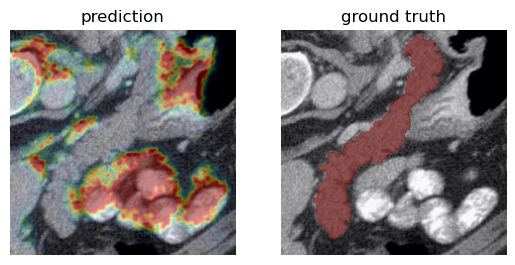

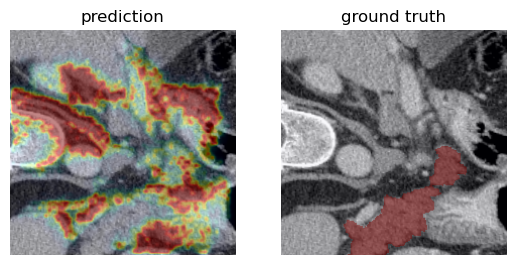

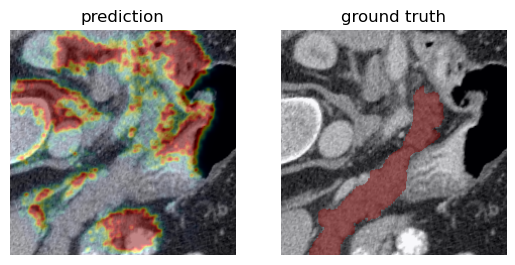

In [48]:
# load the net
model = torch.load('pancreas_model.pt')
# replace it's relu functions
# todo
model = replaceFunc(model)

torch.manual_seed(50)
dice_all = []

for test_idx in range(256,262,2):
    # skip img without pancreas
    if(ds.labels[test_idx]==0):
        continue
    
    img_normalized = dl_test.dataset.imgs[test_idx].unsqueeze(0).to(device)
    img = ds.imgs[test_idx].to(device)
    seg = ds.segmentations[test_idx].to(device)

    # call the guided backprop funktion
    # todo
    guided_grad = guided_backprop(img_normalized, model, seg)


    # visualize the map
    # todo img_normalized.detach()
    plot_activations(img=img.unsqueeze(0), activation_heatmap=guided_grad, segmentation=seg)

    # compute the dice value & append it to dice_all
    # todo
    x, y = oracle_dice(img_normalized[:,1].squeeze().to('cpu'), seg.int().to('cpu'))
    dice_all.append(x)

print('mean dice:',torch.mean(torch.stack(dice_all)).item())

# Bonus task: Explainable pneumonia classification (10 bonus points)
For the bonus task you can implement the CAM method for the pneumonia classification of the very first MDL exercise sheet (Exercise 0).
Therefore
+ adapt the CNN accordingly to become usable with the CAM method
+ extract the CAMs for the **test** data with the index $i\in\{0, 14, 15, 26, 27, 33, 34\}$ (including only samples with pneumonia)
+ visualize them with matplotlib or a similar plotting library of your choice
+ have a closer look at the activation maps. Do you notice something, that indicates an overfitting on the dataset or a false decision base of the CNN for the classification? **Write some short sentences!**

Your results should look similar to these plots:

![cam0](https://drive.google.com/uc?export=view&id=18JBnp637Z6WKHpiQmFUWlGHb-cBfnaEH)
![cam14](https://drive.google.com/uc?export=view&id=1U1os6B4m-FAxCq4TB50jlnTZb5HD9Kn7)
![cam15](https://drive.google.com/uc?export=view&id=1IyNItiLOvbFD-Uqs8yVMM98-4c6rtqtW)
![cam26](https://drive.google.com/uc?export=view&id=1iDmRY3gRoeTwXN6Njrhv5mZqR_Jdvcco)
![cam27](https://drive.google.com/uc?export=view&id=1RxxEgtK47IBVWBoGQR9QusUWYXhiVlxD)
![cam33](https://drive.google.com/uc?export=view&id=1hhmSVIKkecQvmFnjKPo_CnhGMRtwjoaJ)
![cam34](https://drive.google.com/uc?export=view&id=14sWeMsTnSx5V2tLcynXvT8qAb2MVhMHA)